In [1]:
import os
import csv
%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import xgboost as xgb

from sklearn.cluster import KMeans, DBSCAN
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifier 
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
    roc_auc_score,
    roc_curve,
    average_precision_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    accuracy_score
)
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
    cross_val_predict,
    StratifiedKFold,
)

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization,Dropout

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.svm import SVC, LinearSVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from scipy.stats import expon, lognorm, loguniform, randint, uniform

from sklearn.feature_selection import RFECV
from sklearn.utils.class_weight import compute_sample_weight

#import eli5
#import shap

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.4f (+/- %0.4f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)


import shap
from SmartImputer import SmartImputer
from keros_cross_val import keros_cross_val

/Users/seyedarmanabtahi/opt/anaconda3/envs/cpsc330/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# <center> Spaceship Titanic</center>
<br><br><br>
### <center>Arman Abtahi</center>


# Spaceship Titanic

<p style="text-align: justify";>Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.
The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.<br><br>
    While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!<br><br>
To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.<br><br>
Help save them and change history!</p>

In [2]:
df_test =  pd.read_csv("data/test.csv")
df_train =  pd.read_csv("data/train.csv")
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
print("train shape",df_train.shape)
print("test shape",df_test.shape)

train shape (8693, 14)
test shape (4277, 13)


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.<br>
**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.<br>
**CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.<br>
**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.<br>
**Destination** - The planet the passenger will be debarking to.<br>
**Age** - The age of the passenger.<br>
**VIP** - Whether the passenger has paid for special VIP service during the voyage.<br>
**RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.<br>
**Name** - The first and last names of the passenger.<br>
**Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [5]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
numerical_features=["Age","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]
categorical_features=["HomePlanet","Destination"]
binary_features=["CryoSleep","VIP"]
passthrough_features = []
drop_features=["PassengerId","Name","Cabin"]
target="Transported"

numeric_transformer=make_pipeline(SimpleImputer(strategy="median"),StandardScaler())
categorical_transformer=make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown='ignore',sparse=False,drop="first"))
binary_transformer=make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown='ignore',drop="if_binary",sparse=False))
    
preprocessor=make_column_transformer(
    (numeric_transformer,numerical_features),
    (categorical_transformer,categorical_features),
    (binary_transformer,binary_features),
    ("passthrough",passthrough_features),
    ("drop",drop_features),
)

In [7]:
X_train=df_train.drop(columns=target)
y_train=df_train[[target]]
y_train=np.ravel(y_train)*1
X_test=df_test

In [8]:
scores={}
scoring=["accuracy"]
pipe_dc=make_pipeline(preprocessor,DummyClassifier())
scores["DummyClassifier"]=mean_std_cross_val_scores(pipe_dc,  X_train, y_train,  scoring=scoring,cv=5,return_train_score=True)
pipe_lr=make_pipeline(preprocessor,LogisticRegression(max_iter=2000))
scores["LogisticRegression"]=mean_std_cross_val_scores(pipe_lr,  X_train,y_train,scoring=scoring,cv=5,return_train_score=True)
pipe_svc_rbf = make_pipeline(preprocessor, SVC(kernel='rbf',max_iter=20000))
scores["SVC"]=mean_std_cross_val_scores(pipe_svc_rbf,  X_train,y_train,scoring=scoring,cv=5,return_train_score=True)
pd.DataFrame(scores)

,DummyClassifier,LogisticRegression,SVC
fit_time,0.0235 (+/- 0.0037),0.0355 (+/- 0.0032),1.2808 (+/- 0.0580)
score_time,0.0073 (+/- 0.0007),0.0075 (+/- 0.0005),0.5875 (+/- 0.0945)
test_accuracy,0.5036 (+/- 0.0002),0.7857 (+/- 0.0055),0.7891 (+/- 0.0105)
train_accuracy,0.5036 (+/- 0.0000),0.7867 (+/- 0.0023),0.7947 (+/- 0.0022)


Leaderboard score is **0.82043**

Is this good enough?<br>
For industrial purposes yes, but not for Kaggle competitions.

What can be done?

# Exploratory Data Analysis

**Cabin** - Takes the form deck/num/side, where side can be either P for Port or S for Starboard.<br>

In [9]:
X_train[["Cabin"]].head()

,Cabin
0,B/0/P
1,F/0/S
2,A/0/S
3,A/0/S
4,F/1/S


In [10]:
cabin_train=df_train["Cabin"].str.split('/', expand=True)
cabin_train=cabin_train.rename(columns={0: 'cabin_deck', 1: 'cabin_number', 2: 'cabin_side'})
df_train = pd.concat([df_train, cabin_train], axis=1).drop(columns="Cabin")
cabin_train.head()

,cabin_deck,cabin_number,cabin_side
0,B,0,P
1,F,0,S
2,A,0,S
3,A,0,S
4,F,1,S


**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.<br>

In [11]:
X_train[["PassengerId"]].head()

,PassengerId
0,0001_01
1,0002_01
2,0003_01
3,0003_02
4,0004_01


In [12]:
PassengerId_train=df_train["PassengerId"].str.split('_', expand=True).astype(int)
PassengerId_train=PassengerId_train.rename(columns={0: 'GroupId', 1: 'Family'})
for i in range(PassengerId_train.shape[0]):
    member=PassengerId_train.loc[i,"Family"]
    for j in range(member):
        PassengerId_train.loc[i-j,"Family"]=member
df_train = pd.concat([df_train, PassengerId_train], axis=1)
PassengerId_train.head()

,GroupId,Family
0,1,1
1,2,1
2,3,2
3,3,2
4,4,1


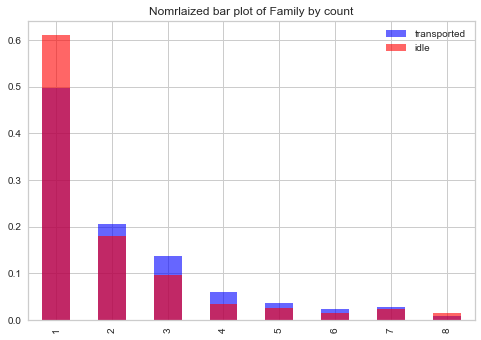

In [13]:
Transported=df_train[df_train[target] == 1]
Idle=df_train[df_train[target] == 0]
trans = Transported["Family"].value_counts(normalize=True).sort_index()
idl = Idle["Family"].value_counts(normalize=True).sort_index()
trans.plot(kind='bar',alpha=0.6, label='transported',color='blue',legend='transported').set_title("Nomrlaized bar plot of Family by count" )
idl.plot(kind='bar',alpha=0.6, label='idle',color='red',legend='idle');

In [14]:
cabin_test=df_test["Cabin"].str.split('/', expand=True)
cabin_test=cabin_test.rename(columns={0: 'cabin_deck', 1: 'cabin_number', 2: 'cabin_side'})
df_test = pd.concat([df_test, cabin_test], axis=1).drop(columns="Cabin")
PassengerId_test=df_test["PassengerId"].str.split('_', expand=True).astype(int)
PassengerId_test=PassengerId_test.rename(columns={0: 'GroupId', 1: 'Family'})
for i in range(PassengerId_test.shape[0]):
    member=PassengerId_test.loc[i,"Family"]
    for j in range(member):
        PassengerId_test.loc[i-j,"Family"]=member
df_test = pd.concat([df_test, PassengerId_test], axis=1)

# Exploratory Data Analysis

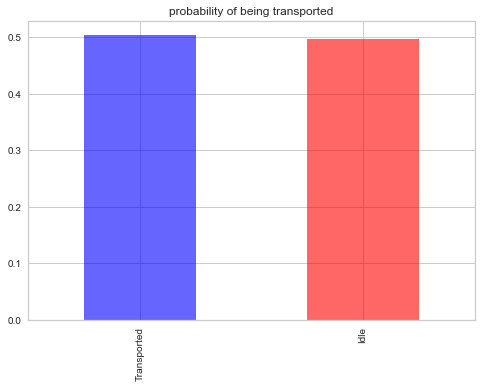

In [15]:
df_train[target].value_counts(normalize=True).rename(index={0:"Idle",1:"Transported"}).plot(kind="bar",color=["blue","red"],alpha=0.6,).set_title("probability of being transported");

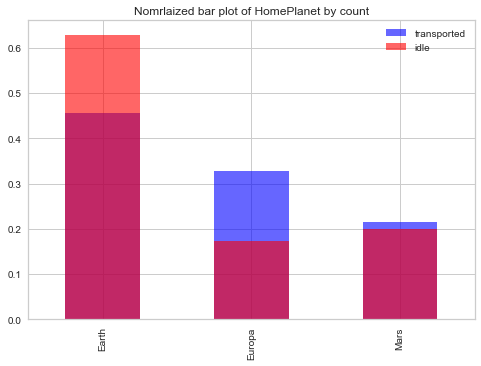

In [16]:
trans = Transported["HomePlanet"].value_counts(normalize=True).sort_index()
idl = Idle["HomePlanet"].value_counts(normalize=True).sort_index()
trans.plot(kind='bar',alpha=0.6, label='transported',color='blue',legend='transported').set_title("Nomrlaized bar plot of HomePlanet by count" )
idl.plot(kind='bar',alpha=0.6, label='idle',color='red',legend='idle');

Europa, or Jupiter II, is the smallest of the four Galilean moons orbiting Jupiter

In [17]:
df_train["cabin_deck"].sort_values().unique()

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', nan], dtype=object)

## Home Planet: Mars

<AxesSubplot:>

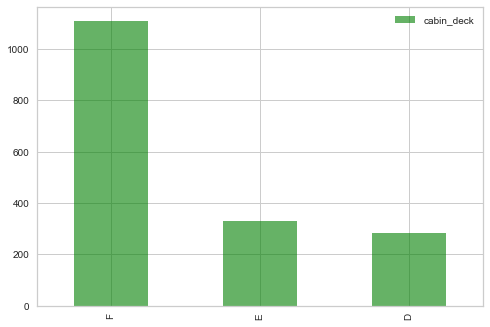

In [18]:
df_train[df_train["HomePlanet"]=="Mars"]["cabin_deck"].value_counts().plot(kind='bar',alpha=0.6, legend='Mars',color='green')

In [19]:
df_train["cabin_deck"].sort_values().unique()

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', nan], dtype=object)

## Home Planet: Earth

<AxesSubplot:>

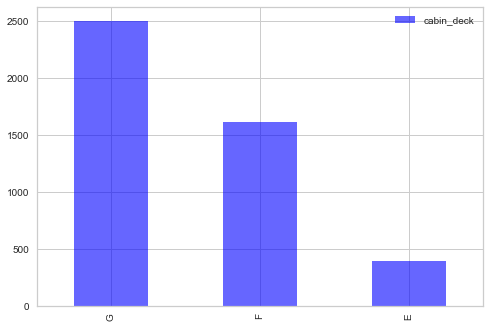

In [20]:
df_train[df_train["HomePlanet"]=="Earth"]["cabin_deck"].value_counts().plot(kind='bar',alpha=0.6, legend='Earth',color='blue')

In [21]:
df_train["cabin_deck"].sort_values().unique()

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', nan], dtype=object)

## Home Planet: Europa

<AxesSubplot:>

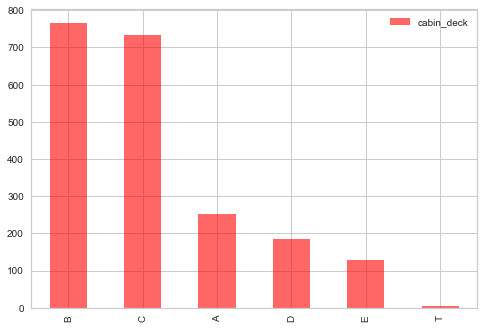

In [22]:
df_train[df_train["HomePlanet"]=="Europa"]["cabin_deck"].value_counts().plot(kind='bar',alpha=0.6, legend='Europa',color='red')

# Smart Imputation

In [23]:
X_train=df_train.drop(columns=target)
y_train=df_train[[target]]
X_test=df_test
numerical_features=["Age","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck","cabin_number"]
categorical_features=["HomePlanet","Destination","cabin_deck","cabin_side","Family"]
binary_features=["CryoSleep","VIP"]
passthrough_features = []
drop_features=["PassengerId","GroupId","Name"]

dic={"numerics":numerical_features,
     "categories":categorical_features,
     "binaries":binary_features,
     "passthrough":passthrough_features,
     "drops":drop_features
    }
features=numerical_features+categorical_features+binary_features+passthrough_features+drop_features
#assert set(features)==set(feats)+set
Impute_df=pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

In [24]:
Impute_df.loc[Impute_df[Impute_df["cabin_deck"]=="G"]["HomePlanet"].index,"HomePlanet"]="Earth"
Impute_df.loc[Impute_df[(Impute_df["cabin_deck"]=="A")|(Impute_df["cabin_deck"]=="B")|(Impute_df["cabin_deck"]=="C")|(Impute_df["cabin_deck"]=="T")]["HomePlanet"].index,"HomePlanet"]="Europa"

In [25]:
Imputed_df=SmartImputer(Impute_df,dic)

In [26]:
X_train=Imputed_df.head(X_train.shape[0]).reset_index(drop=True)
X_test=Imputed_df.tail(X_test.shape[0]).reset_index(drop=True)  

SmartImputer is a function I wrote that uses macine learning for each feauture to predict and impute missing values. 

In [27]:
def SmartImputer(X,dic):
    numerical_features=dic["numerics"]
    categorical_features=dic["categories"]
    binary_features=dic["binaries"]
    passthrough_features=dic["passthrough"]
    drop_features=dic["drops"]
    Impute_list=X.columns[X.isna().any()].tolist()
    numeric_transformer=make_pipeline(SimpleImputer(strategy="median"),StandardScaler())
    categorical_transformer=make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown='ignore',sparse=False,drop="first"))
    binary_transformer=make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown='ignore',drop="if_binary",sparse=False))
    preprocessor=make_column_transformer((numeric_transformer,numerical_features),(categorical_transformer,categorical_features),(binary_transformer,binary_features),("passthrough",passthrough_features),("drop",drop_features),)
    list_features_type=["numerical_features","categorical_features","binary_features","passthrough_features"]
    pipe_rf_classifier = make_pipeline(preprocessor, RandomForestClassifier())
    pipe_rf_regressor = make_pipeline(preprocessor, RandomForestRegressor())
    for Impute_target in Impute_list:
        Impute_df_train=X[X[Impute_target].notna()]
        Impute_df_test=X[X[Impute_target].isna()]
        Impute_X_train=Impute_df_train.drop(columns=Impute_target)
        Impute_y_train=Impute_df_train[Impute_target]
        Impute_X_test=Impute_df_test.drop(columns=Impute_target)
        for types in list_features_type:
            if Impute_target in locals()[types]:
                locals()[types].remove(Impute_target)    
                if types=="numerical_features":
                    pipe=pipe_rf_regressor
                else:
                    pipe=pipe_rf_classifier  
                if types=="binary_features":
                    Impute_y_train=Impute_y_train.astype('int')
                pipe.fit(Impute_X_train,Impute_y_train);
                Impute_y_pred=pipe.predict(Impute_X_test)
                Impute_y_pred=pd.DataFrame(Impute_y_pred,index=Impute_X_test.index, columns=[Impute_target])
                X=pd.concat([pd.concat([Impute_X_train,Impute_y_train], axis=1),pd.concat([Impute_X_test,Impute_y_pred], axis=1)],axis=0).sort_index()
                locals()[types].append(Impute_target)
                break
    return X

# Feature Engineering

In [28]:
GroupEarth_train=(X_train["cabin_deck"]=="G")
GroupEuropa_train=(((X_train["cabin_deck"]=="A")|(X_train["cabin_deck"]=="B")|(X_train["cabin_deck"]=="C")|(X_train["cabin_deck"]=="T")))
GroupMulti_train=(((X_train["cabin_deck"]=="D")|(X_train["cabin_deck"]=="E")|(X_train["cabin_deck"]=="F")))
tot_train=X_train["RoomService"]+X_train["FoodCourt"]+X_train["ShoppingMall"]+X_train["Spa"]+X_train["VRDeck"]+1 #+1 to avoid zero division
cabin_CS_train=(X_train["cabin_deck"]+X_train["cabin_side"])=="CS"
spa_Europa_train=(X_train["Spa"]/tot_train)*(X_train["HomePlanet"]=="Europa")*1

In [29]:
GroupEarth_test=(X_test["cabin_deck"]=="G")
GroupEuropa_test=(((X_test["cabin_deck"]=="A")|(X_test["cabin_deck"]=="B")|(X_test["cabin_deck"]=="C")|(X_test["cabin_deck"]=="T")))
GroupMulti_test=(((X_test["cabin_deck"]=="D")|(X_test["cabin_deck"]=="E")|(X_test["cabin_deck"]=="F")))
tot_test=X_test["RoomService"]+X_test["FoodCourt"]+X_test["ShoppingMall"]+X_test["Spa"]+X_test["VRDeck"]+1
cabin_CS_test=(X_test["cabin_deck"]+X_test["cabin_side"])=="CS"
spa_Europa_test=(X_test["Spa"]/tot_train)*(X_test["HomePlanet"]=="Europa")*1

X_train.insert(0,"TotalSpent",np.log(tot_train))
X_train.insert(0,"RoomService/tot",X_train["RoomService"]/tot_train)
X_train.insert(0,"FoodCourt/tot",X_train["FoodCourt"]/tot_train)
X_train.insert(0,"ShoppingMall/tot",X_train["ShoppingMall"]/tot_train)
X_train.insert(0,"Spa/tot",X_train["Spa"]/tot_train)
X_train.insert(0,"VRDeck/tot",X_train["VRDeck"]/tot_train)
X_train.insert(0,"GroupEarth",GroupEarth_train)
X_train.insert(0,"GroupEuropa",GroupEuropa_train)
X_train.insert(0,"GroupMulti",GroupMulti_train)
X_train.insert(0,"cabin_CS",cabin_CS_train)
X_train.insert(0,"spa_Europa",spa_Europa_train)


X_test.insert(0,"TotalSpent",np.log(tot_test))
X_test.insert(0,"RoomService/tot",X_test["RoomService"]/tot_test)
X_test.insert(0,"FoodCourt/tot",X_test["FoodCourt"]/tot_test)
X_test.insert(0,"ShoppingMall/tot",X_test["ShoppingMall"]/tot_test)
X_test.insert(0,"Spa/tot",X_test["Spa"]/tot_test)
X_test.insert(0,"VRDeck/tot",X_test["VRDeck"]/tot_test)
X_test.insert(0,"GroupEarth",GroupEarth_test)
X_test.insert(0,"GroupEuropa",GroupEuropa_test)
X_test.insert(0,"GroupMulti",GroupMulti_test)
X_test.insert(0,"cabin_CS",cabin_CS_test)
X_test.insert(0,"spa_Europa",spa_Europa_test)


In [30]:
numerical_features=numerical_features+["TotalSpent","RoomService/tot","FoodCourt/tot","ShoppingMall/tot","Spa/tot","VRDeck/tot","spa_Europa"]
binary_features=binary_features+["GroupEarth","GroupEuropa","GroupMulti","cabin_CS"]

numeric_transformer=make_pipeline(SimpleImputer(strategy="median"),StandardScaler())
categorical_transformer=make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown='ignore',sparse=False,drop="first"))
binary_transformer=make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown='ignore',drop="if_binary",sparse=False))
    
preprocessor=make_column_transformer(
    (numeric_transformer,numerical_features),
    (categorical_transformer,categorical_features),
    (binary_transformer,binary_features),
    ("passthrough",passthrough_features),
    ("drop",drop_features),
)

X_train_transformed=preprocessor.fit_transform(X_train)

column_names=(
    numerical_features
    +preprocessor.named_transformers_["pipeline-2"].named_steps["onehotencoder"].get_feature_names_out(categorical_features).tolist()
    +preprocessor.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out(binary_features).tolist()
    +passthrough_features
)

In [31]:
np.transpose(column_names)

array(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'cabin_number', 'TotalSpent', 'RoomService/tot', 'FoodCourt/tot',
       'ShoppingMall/tot', 'Spa/tot', 'VRDeck/tot', 'spa_Europa',
       'Family_2', 'Family_3', 'Family_4', 'Family_5', 'Family_6',
       'Family_7', 'Family_8', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e',
       'cabin_deck_B', 'cabin_deck_C', 'cabin_deck_D', 'cabin_deck_E',
       'cabin_deck_F', 'cabin_deck_G', 'cabin_deck_T', 'cabin_side_S',
       'CryoSleep_1', 'VIP_1', 'GroupEarth_True', 'GroupEuropa_True',
       'GroupMulti_True', 'cabin_CS_True'], dtype='<U25')

In [32]:
X_train_transformed=pd.DataFrame(X_train_transformed,index=X_train.index, columns=column_names)

## Heat Map

In [33]:
cor = pd.concat((y_train, X_train_transformed), axis=1).corr()
plt.figure(figsize=(25, 25))
sns.set(font_scale=1)

<Figure size 1800x1800 with 0 Axes>

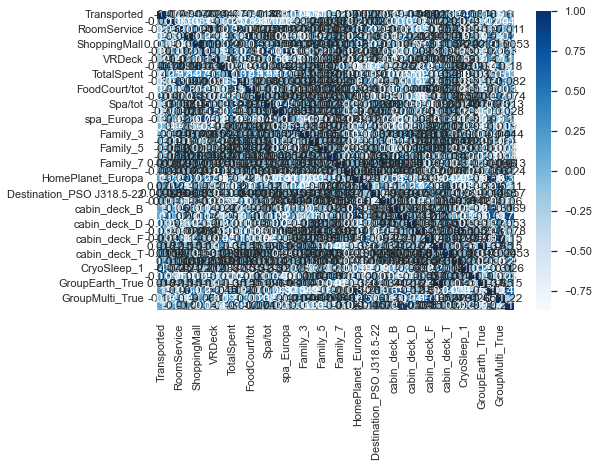

In [34]:
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

## Linear model and features importance

In [35]:
y_train=np.ravel(y_train)*1
pipe_lr=make_pipeline(preprocessor,LogisticRegression(max_iter=2000))
scores["LogisticRegression Improv"]=mean_std_cross_val_scores(pipe_lr,  X_train,y_train,scoring=scoring,cv=5,return_train_score=True)
pipe_svc_rbf = make_pipeline(preprocessor, SVC(kernel='rbf',max_iter=20000))
scores["SVC Improv"]=mean_std_cross_val_scores(pipe_svc_rbf,  X_train,y_train,scoring=scoring,cv=5,return_train_score=True)
pd.DataFrame(scores)

,DummyClassifier,LogisticRegression,SVC,LogisticRegression Improv,SVC Improv
fit_time,0.0235 (+/- 0.0037),0.0355 (+/- 0.0032),1.2808 (+/- 0.0580),0.1445 (+/- 0.0127),1.3764 (+/- 0.0192)
score_time,0.0073 (+/- 0.0007),0.0075 (+/- 0.0005),0.5875 (+/- 0.0945),0.0138 (+/- 0.0008),0.8988 (+/- 0.0669)
test_accuracy,0.5036 (+/- 0.0002),0.7857 (+/- 0.0055),0.7891 (+/- 0.0105),0.7919 (+/- 0.0121),0.8041 (+/- 0.0121)
train_accuracy,0.5036 (+/- 0.0000),0.7867 (+/- 0.0023),0.7947 (+/- 0.0022),0.8004 (+/- 0.0036),0.8155 (+/- 0.0031)


In [36]:
pipe_lr.fit(X_train,y_train)
lr_coefs = pd.DataFrame(pipe_lr[1].coef_.T, index=column_names, columns=["Coefficient"])
lr_coefs.sort_values(by=["Coefficient"],ascending=False).T

,cabin_CS_True,HomePlanet_Europa,cabin_deck_B,cabin_deck_C,CryoSleep_1,FoodCourt,cabin_side_S,HomePlanet_Mars,ShoppingMall,cabin_deck_D,...,GroupEuropa_True,cabin_deck_T,VIP_1,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,TotalSpent,Family_8,RoomService,Spa,VRDeck
Coefficient,3.271189,1.676866,1.129281,0.955927,0.885049,0.688944,0.52641,0.379835,0.330429,0.322492,...,-0.290908,-0.312751,-0.321238,-0.378767,-0.448877,-0.464331,-0.496357,-0.542168,-1.85932,-1.962567


# Polynomial Features and Feature Selection

In [37]:
poly_transformer = PolynomialFeatures(
    degree=2, interaction_only=True, include_bias=True
)

In [38]:
feature_selector=RFECV(LogisticRegression(max_iter=2000), cv=3,min_features_to_select=5)

In [39]:
pipe_lr_poly_fs = make_pipeline(preprocessor ,poly_transformer,feature_selector,LogisticRegression(max_iter=2000))
pipe_lr_poly_fs.fit(X_train,y_train);
features_poly = pipe_lr_poly_fs.named_steps["polynomialfeatures"].get_feature_names_out(column_names)
selected_features_poly=np.array(features_poly)[pipe_lr_poly_fs.named_steps["rfecv"].support_]
lr_poly_fs_coefs = pd.DataFrame(pipe_lr_poly_fs.named_steps["logisticregression"].coef_.T, index=selected_features_poly, columns=["Coefficient"])
import warnings
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [40]:
lr_poly_fs_coefs.sort_values(by=["Coefficient"],ascending=False)

,Coefficient
VRDeck Spa/tot,2.344989
HomePlanet_Europa CryoSleep_1,2.057141
VRDeck HomePlanet_Europa,1.834718
cabin_deck_B cabin_side_S,1.566287
FoodCourt/tot cabin_CS_True,1.440817
...,...
TotalSpent GroupMulti_True,-1.411455
RoomService/tot VIP_1,-1.465060
RoomService/tot cabin_deck_C,-1.577028
Spa/tot HomePlanet_Europa,-1.984040


## Different classifiers

In [41]:
pipe_lr = make_pipeline(preprocessor, LogisticRegression(max_iter=2000))
pipe_r = make_pipeline(preprocessor, RidgeClassifier(max_iter=2000))
pipe_knn = make_pipeline(preprocessor, KNeighborsClassifier())
pipe_svc = make_pipeline(preprocessor, SVC(kernel='linear',max_iter=20000))
pipe_svc_rbf = make_pipeline(preprocessor, SVC(kernel='rbf',max_iter=20000))
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier())
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier())
pipe_xgb = make_pipeline(preprocessor, XGBClassifier(verbosity=0,use_label_encoder=False))
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier())
pipe_catboost = make_pipeline(preprocessor, CatBoostClassifier(verbose=0))

classifiers = {
    "logistic regression": pipe_lr,
    "ridge classifier": pipe_r,
    "knn": pipe_knn,
    "svc": pipe_svc,
    "svcRBF": pipe_svc_rbf,
    "decision tree": pipe_dt,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catboost,
}

# Hyperparameter optimization

We use RandomizedSearchCV to tune all classifiers. 

In [42]:
### 1. LogosticRegresion

param_dist = {
    "logisticregression__C": loguniform(0.005,100),
}

random_search_lr = RandomizedSearchCV(pipe_lr, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5,scoring="accuracy",random_state=123)
random_search_lr.fit(X_train, y_train);


### 2. CatBoost
param_dist = {
    "catboostclassifier__max_depth": [2,3,4,5,6,7,8,9,10,20],
    "catboostclassifier__learning_rate": [0.05, 0.1,0.2,0.5],
    "catboostclassifier__n_estimators": [5,10,20,50,75,100,150,200],
    "catboostclassifier__loss_function": ["MultiClass","Logloss","CrossEntropy"],
}
random_search_cb = RandomizedSearchCV(pipe_catboost, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5,scoring="accuracy",random_state=123)
random_search_cb.fit(X_train, y_train);

### 3. Random Forest
param_dist = {
    "randomforestclassifier__n_estimators": [5,10,20,50,75,100,150,200,500],
    "randomforestclassifier__max_depth": [5,10,20,50,75,100,150,200],
    "randomforestclassifier__class_weight": ["balanced"],
    "randomforestclassifier__max_features": ["auto"],
    "randomforestclassifier__bootstrap": [True],
    
}
random_search_rf = RandomizedSearchCV(pipe_rf, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5,scoring="accuracy",random_state=123)
random_search_rf.fit(X_train, y_train);



### 4. LightGBM

param_dist = {
    #"lgbmclassifier__lambda_l1": [0,1,10,20,50,75,100],
   # "lgbmclassifier__lambda_l2": [0,1,10,20,50,75,100],
    "lgbmclassifier__n_estimators": [2,5,10,20,50,75,100,150,200],
    "lgbmclassifier__num_leaves":  [2,5,10,20,50,75,100,150,200],
    "lgbmclassifier__min_child_samples":  [2,5,10,20,50,75,100,150,200],
    "lgbmclassifier__max_depth": [2,5,10,20,50,75,100,150,200],
}
random_search_lgbm = RandomizedSearchCV(pipe_lgbm, param_distributions=param_dist, n_jobs=-1, n_iter=30, cv=5,scoring="accuracy",random_state=123)
random_search_lgbm.fit(X_train, y_train);



### 5. XGBoost

param_dist = {
    "xgbclassifier__max_depth": [2,3,4,5,7,10,20],
    "xgbclassifier__min_child_weight": [0.01,0.1,0.5,0.75,1],
    "xgbclassifier__subsample": [0.1,0.5,0.75,1],
    "xgbclassifier__n_estimators": [2,5,10,20,50,75,100,150,200],
    "xgbclassifier__learning_rate": [ 0.1, 0.2, 0.3],
    "xgbclassifier__eta": [0.05, 0.1, 0.2, 0.3],
}
random_search_xgb = RandomizedSearchCV(pipe_xgb, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5,scoring="accuracy",random_state=123)
random_search_xgb.fit(X_train, y_train);



### 6. SVC

param_dist = {
    "svc__C": loguniform(0.001,100),
    "svc__gamma": loguniform(0.001,10),
}

random_search_svc = RandomizedSearchCV(pipe_svc_rbf, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5,scoring="accuracy",random_state=123)
random_search_svc.fit(X_train, y_train);


### 7. knn
param_dist = {
    "kneighborsclassifier__n_neighbors": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
}

random_search_knn = RandomizedSearchCV(pipe_knn, param_distributions=param_dist, n_jobs=-1, n_iter=10, cv=5,scoring="accuracy")
random_search_knn.fit(X_train, y_train);

### 8. ridge
param_dist = {
    "ridgeclassifier__alpha": loguniform(0.005,100),
}

random_search_r = RandomizedSearchCV(pipe_r, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5,scoring="accuracy")
random_search_r.fit(X_train, y_train);



10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/seyedarmanabtahi/opt/anaconda3/envs/cpsc330/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/seyedarmanabtahi/opt/anaconda3/envs/cpsc330/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/seyedarmanabtahi/opt/anaconda3/envs/cpsc330/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features

In [43]:
classifiers={
             "LR": random_search_lr.best_estimator_,
             "R": random_search_r.best_estimator_,
             "CB":random_search_cb.best_estimator_,
             "RF":random_search_rf.best_estimator_,
             "LGBM":random_search_lgbm.best_estimator_,
             "XGB":random_search_xgb.best_estimator_,
             "SVC":random_search_svc.best_estimator_,
             "knn":random_search_knn.best_estimator_,
}

# Test

### Stacking

In [44]:
pred={}
stacking_model = StackingClassifier(list(classifiers.items()))
stacking_model.fit(X_train, y_train);
pred["stacking"] = stacking_model.predict(X_test)
prediction_stacking=pd.concat([X_test["PassengerId"],pd.DataFrame(pred["stacking"]==1,columns=["Transported"])], axis=1)
prediction_stacking.to_csv ("stacking"+".csv", index = False, header=True)

pd.DataFrame(
    data=stacking_model.final_estimator_.coef_[0],
    index=classifiers.keys(),
    columns=["Coefficient"],
)

,Coefficient
LR,-0.113037
R,0.782543
CB,-1.064423
RF,2.176389
LGBM,4.711868
XGB,-1.753753
SVC,0.025623
knn,0.556288


Let's submit

The Kaggle score is  0.80173

# We can do better

# KMeans
Maybe we can cluster X into 2 groups and perform classification on each group separately.

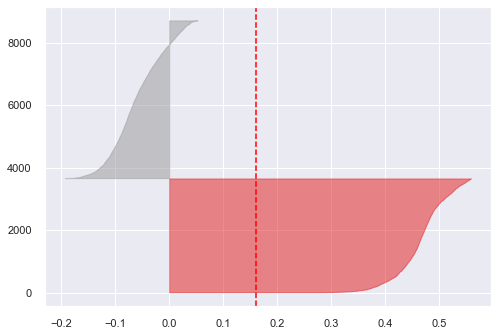

In [66]:
model=KMeans(n_clusters=2,random_state=123)
visualizer=SilhouetteVisualizer(model,color="yellowbrick")
visualizer.fit(X_train_transformed);

In [46]:
pipe_KMeans=make_pipeline(preprocessor,KMeans(n_clusters=2,random_state=123))
pipe_KMeans.fit(X_train);
y_clusters=pipe_KMeans.predict(X_train)
X_train_sub1=X_train[y_clusters==0]
y_train_sub1=y_train[y_clusters==0]
X_train_sub2=X_train[y_clusters==1]
y_train_sub2=y_train[y_clusters==1]

In [47]:
X_train.shape,X_train_sub1.shape,X_train_sub2.shape

((8693, 28), (3643, 28), (5050, 28))

In [48]:
y_train.sum()/y_train.shape[0], y_train_sub1.sum()/y_train_sub1.shape[0],  y_train_sub2.sum()/y_train_sub2.shape[0]

(0.5036236051995858, 0.7875377436178973, 0.2988118811881188)

In [49]:
scores={}
scores["LogisticRegression"]=mean_std_cross_val_scores(pipe_lr,  X_train,y_train,scoring=scoring,cv=5,return_train_score=True)
scores["LogisticRegression_sub1"]=mean_std_cross_val_scores(pipe_lr,  X_train_sub1,y_train_sub1,scoring=scoring,cv=5,return_train_score=True)
scores["LogisticRegression_sub2"]=mean_std_cross_val_scores(pipe_lr,  X_train_sub2,y_train_sub2,scoring=scoring,cv=5,return_train_score=True)
pd.DataFrame(scores)

,LogisticRegression,LogisticRegression_sub1,LogisticRegression_sub2
fit_time,0.1417 (+/- 0.0182),0.0551 (+/- 0.0035),0.0838 (+/- 0.0016)
score_time,0.0130 (+/- 0.0008),0.0087 (+/- 0.0001),0.0109 (+/- 0.0011)
test_accuracy,0.7919 (+/- 0.0121),0.7925 (+/- 0.0186),0.8000 (+/- 0.0134)
train_accuracy,0.8004 (+/- 0.0036),0.8022 (+/- 0.0063),0.8117 (+/- 0.0013)


In [50]:
### 1. LogosticRegresion

param_dist = {
    "logisticregression__C": loguniform(0.005,100),
}

random_search_lr_sub1 = RandomizedSearchCV(pipe_lr, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5,scoring="accuracy",random_state=123)
random_search_lr_sub1.fit(X_train_sub1, y_train_sub1);


### 2. CatBoost
param_dist = {
    "catboostclassifier__max_depth": [2,3,4,5,6,7,8,9,10,20],
    "catboostclassifier__learning_rate": [0.05, 0.1,0.2,0.5],
    "catboostclassifier__n_estimators": [5,10,20,50,75,100,150,200],
    "catboostclassifier__loss_function": ["MultiClass","Logloss","CrossEntropy"],
}
random_search_cb_sub1 = RandomizedSearchCV(pipe_catboost, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5,scoring="accuracy",random_state=123)
random_search_cb_sub1.fit(X_train_sub1, y_train_sub1);

### 3. Random Forest
param_dist = {
    "randomforestclassifier__n_estimators": [5,10,20,50,75,100,150,200,500],
    "randomforestclassifier__max_depth": [5,10,20,50,75,100,150,200],
    "randomforestclassifier__class_weight": ["balanced"],
    "randomforestclassifier__max_features": ["auto"],
    "randomforestclassifier__bootstrap": [True],
    
}
random_search_rf_sub1 = RandomizedSearchCV(pipe_rf, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5,scoring="accuracy",random_state=123)
random_search_rf_sub1.fit(X_train_sub1, y_train_sub1);



### 4. LightGBM

param_dist = {
    #"lgbmclassifier__lambda_l1": [0,1,10,20,50,75,100],
   # "lgbmclassifier__lambda_l2": [0,1,10,20,50,75,100],
    "lgbmclassifier__n_estimators": [2,5,10,20,50,75,100,150,200],
    "lgbmclassifier__num_leaves":  [2,5,10,20,50,75,100,150,200],
    "lgbmclassifier__min_child_samples":  [2,5,10,20,50,75,100,150,200],
    "lgbmclassifier__max_depth": [2,5,10,20,50,75,100,150,200],
}
random_search_lgbm_sub1 = RandomizedSearchCV(pipe_lgbm, param_distributions=param_dist, n_jobs=-1, n_iter=30, cv=5,scoring="accuracy",random_state=123)
random_search_lgbm_sub1.fit(X_train_sub1, y_train_sub1);



### 5. XGBoost

param_dist = {
    "xgbclassifier__max_depth": [2,3,4,5,7,10,20],
    "xgbclassifier__min_child_weight": [0.01,0.1,0.5,0.75,1],
    "xgbclassifier__subsample": [0.1,0.5,0.75,1],
    "xgbclassifier__n_estimators": [2,5,10,20,50,75,100,150,200],
    "xgbclassifier__learning_rate": [ 0.1, 0.2, 0.3],
    "xgbclassifier__eta": [0.05, 0.1, 0.2, 0.3],
}
random_search_xgb_sub1 = RandomizedSearchCV(pipe_xgb, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5,scoring="accuracy",random_state=123)
random_search_xgb_sub1.fit(X_train_sub1, y_train_sub1);



### 6. SVC

param_dist = {
    "svc__C": loguniform(0.001,100),
    "svc__gamma": loguniform(0.001,10),
}

random_search_svc_sub1 = RandomizedSearchCV(pipe_svc_rbf, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5,scoring="accuracy",random_state=123)
random_search_svc_sub1.fit(X_train_sub1, y_train_sub1);


### 7. knn
param_dist = {
    "kneighborsclassifier__n_neighbors": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
}

random_search_knn_sub1 = RandomizedSearchCV(pipe_knn, param_distributions=param_dist, n_jobs=-1, n_iter=10, cv=5,scoring="accuracy")
random_search_knn_sub1.fit(X_train_sub1, y_train_sub1);

### 8. ridge
param_dist = {
    "ridgeclassifier__alpha": loguniform(0.005,100),
}

random_search_r_sub1 = RandomizedSearchCV(pipe_r, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5,scoring="accuracy")
random_search_r_sub1.fit(X_train_sub1, y_train_sub1);



10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/seyedarmanabtahi/opt/anaconda3/envs/cpsc330/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/seyedarmanabtahi/opt/anaconda3/envs/cpsc330/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/seyedarmanabtahi/opt/anaconda3/envs/cpsc330/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features

In [51]:
### 1. LogosticRegresion

param_dist = {
    "logisticregression__C": loguniform(0.005,100),
}

random_search_lr_sub2 = RandomizedSearchCV(pipe_lr, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5,scoring="accuracy",random_state=123)
random_search_lr_sub2.fit(X_train_sub2, y_train_sub2);


### 2. CatBoost
param_dist = {
    "catboostclassifier__max_depth": [2,3,4,5,6,7,8,9,10,20],
    "catboostclassifier__learning_rate": [0.05, 0.1,0.2,0.5],
    "catboostclassifier__n_estimators": [5,10,20,50,75,100,150,200],
    "catboostclassifier__loss_function": ["MultiClass","Logloss","CrossEntropy"],
}
random_search_cb_sub2 = RandomizedSearchCV(pipe_catboost, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5,scoring="accuracy",random_state=123)
random_search_cb_sub2.fit(X_train_sub2, y_train_sub2);

### 3. Random Forest
param_dist = {
    "randomforestclassifier__n_estimators": [5,10,20,50,75,100,150,200,500],
    "randomforestclassifier__max_depth": [5,10,20,50,75,100,150,200],
    "randomforestclassifier__class_weight": ["balanced"],
    "randomforestclassifier__max_features": ["auto"],
    "randomforestclassifier__bootstrap": [True],
    
}
random_search_rf_sub2 = RandomizedSearchCV(pipe_rf, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5,scoring="accuracy",random_state=123)
random_search_rf_sub2.fit(X_train_sub2, y_train_sub2);


### 4. LightGBM

param_dist = {
    #"lgbmclassifier__lambda_l1": [0,1,10,20,50,75,100],
   # "lgbmclassifier__lambda_l2": [0,1,10,20,50,75,100],
    "lgbmclassifier__n_estimators": [2,5,10,20,50,75,100,150,200],
    "lgbmclassifier__num_leaves":  [2,5,10,20,50,75,100,150,200],
    "lgbmclassifier__min_child_samples":  [2,5,10,20,50,75,100,150,200],
    "lgbmclassifier__max_depth": [2,5,10,20,50,75,100,150,200],
}
random_search_lgbm_sub2 = RandomizedSearchCV(pipe_lgbm, param_distributions=param_dist, n_jobs=-1, n_iter=30, cv=5,scoring="accuracy",random_state=123)
random_search_lgbm_sub2.fit(X_train_sub2, y_train_sub2);



### 5. XGBoost

param_dist = {
    "xgbclassifier__max_depth": [2,3,4,5,7,10,20],
    "xgbclassifier__min_child_weight": [0.01,0.1,0.5,0.75,1],
    "xgbclassifier__subsample": [0.1,0.5,0.75,1],
    "xgbclassifier__n_estimators": [2,5,10,20,50,75,100,150,200],
    "xgbclassifier__learning_rate": [ 0.1, 0.2, 0.3],
    "xgbclassifier__eta": [0.05, 0.1, 0.2, 0.3],
}
random_search_xgb_sub2 = RandomizedSearchCV(pipe_xgb, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5,scoring="accuracy",random_state=123)
random_search_xgb_sub2.fit(X_train_sub2, y_train_sub2);



### 6. SVC

param_dist = {
    "svc__C": loguniform(0.001,100),
    "svc__gamma": loguniform(0.001,10),
}

random_search_svc_sub2 = RandomizedSearchCV(pipe_svc_rbf, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5,scoring="accuracy",random_state=123)
random_search_svc_sub2.fit(X_train_sub2, y_train_sub2);


### 7. knn
param_dist = {
    "kneighborsclassifier__n_neighbors": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
}

random_search_knn_sub2 = RandomizedSearchCV(pipe_knn, param_distributions=param_dist, n_jobs=-1, n_iter=10, cv=5,scoring="accuracy")
random_search_knn_sub2.fit(X_train_sub2, y_train_sub2);

### 8. ridge
param_dist = {
    "ridgeclassifier__alpha": loguniform(0.005,100),
}

random_search_r_sub2 = RandomizedSearchCV(pipe_r, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5,scoring="accuracy")
random_search_r_sub2.fit(X_train_sub2, y_train_sub2);



10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/seyedarmanabtahi/opt/anaconda3/envs/cpsc330/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/seyedarmanabtahi/opt/anaconda3/envs/cpsc330/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/seyedarmanabtahi/opt/anaconda3/envs/cpsc330/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit
    self._fit(X, y, cat_features, text_features, embedding_features

In [52]:
classifiers_sub1={
             "LR_sub1": random_search_lr_sub1.best_estimator_,
             "R_sub1": random_search_r_sub1.best_estimator_,
             "CB_sub1":random_search_cb_sub1.best_estimator_,
             "RF_sub1":random_search_rf_sub1.best_estimator_,
             "LGBM_sub1":random_search_lgbm_sub1.best_estimator_,
             "XGB_sub1":random_search_xgb_sub1.best_estimator_,
             "SVC_sub1":random_search_svc_sub1.best_estimator_,
             "knn_sub1":random_search_knn_sub1.best_estimator_,
}

In [53]:
classifiers_sub2={
             "LR_sub2": random_search_lr_sub2.best_estimator_,
             "R_sub2": random_search_r_sub2.best_estimator_,
             "CB_sub2":random_search_cb_sub2.best_estimator_,
             "RF_sub2":random_search_rf_sub2.best_estimator_,
             "LGBM_sub2":random_search_lgbm_sub2.best_estimator_,
             "XGB_sub2":random_search_xgb_sub2.best_estimator_,
             "SVC_sub2":random_search_svc_sub2.best_estimator_,
             "knn_sub2":random_search_knn_sub2.best_estimator_,
}

### Using KMeans
I use K_means to get the best stacking on each group and then merge two predictions and submit. 

In [54]:
y_clusters=pipe_KMeans.predict(X_test)
X_test_sub1=X_test[y_clusters==0]
X_test_sub2=X_test[y_clusters==1]

In [55]:
stacking_model_sub1 = StackingClassifier(list(classifiers_sub1.items()))
stacking_model_sub1.fit(X_train_sub1, y_train_sub1);
pred_sub1= stacking_model_sub1.predict(X_test_sub1)
prediction_sub1=pd.concat([X_test_sub1["PassengerId"],pd.DataFrame(pred_sub1==1,index=X_test_sub1.index,columns=["Transported"])], axis=1)

In [56]:
stacking_model_sub2 = StackingClassifier(list(classifiers_sub2.items()))
stacking_model_sub2.fit(X_train_sub2, y_train_sub2);
pred_sub2= stacking_model_sub2.predict(X_test_sub2)
prediction_sub2=pd.concat([X_test_sub2["PassengerId"],pd.DataFrame(pred_sub2==1,index=X_test_sub2.index,columns=["Transported"])], axis=1)

In [57]:
#using K_means
prediction_kmeans=pd.concat([prediction_sub1,prediction_sub2]).sort_index()
prediction_kmeans.to_csv ("Stacking_KMeans"+".csv", index = False, header=True)

In [58]:
#only sub1
prediction_stacking_sub1=prediction_stacking.copy()
for i,j in enumerate(prediction_sub1.index):
    prediction_stacking_sub1.iloc[j]=prediction_sub1.iloc[i]
prediction_stacking_sub1.to_csv ("stacking_sub1"+".csv", index = False, header=True)

Submit... score= **0.80874**


# What else? How can we imrove the score?

I used Neural Nets and the score was better than each individual classifier, but couln't beat the stacking score.

Tuning NN is not trivial. The number of layers and nodes are still kind of mistery!

It is hard to put keras NN into your stacking classifier. Unless you right your own stacking code.

# Neural Nets 

In [59]:
def get_model(size):
    pipe_NN = make_pipeline(preprocessor, Sequential())
    pipe_NN['sequential'].add(Dense(100, input_dim=size,activation='softmax'))
    pipe_NN['sequential'].add(BatchNormalization())
    pipe_NN['sequential'].add(Dropout(0.5))
    pipe_NN['sequential'].add(Dense(15,activation='relu'))
    pipe_NN['sequential'].add(BatchNormalization())
    pipe_NN['sequential'].add(Dropout(0.5))
    pipe_NN['sequential'].add(Dense(5,activation='softmax'))
    pipe_NN['sequential'].add(BatchNormalization())
    pipe_NN['sequential'].add(Dropout(0.5))
    pipe_NN['sequential'].add(Dense(1,activation='sigmoid'))
    pipe_NN['sequential'].compile(loss="binary_crossentropy",optimizer="rmsprop",metrics="accuracy")
    return pipe_NN

In [60]:
def keros_cross_val(model,X,y,**kwargs):
    epochs = kwargs["epochs"] if "epochs" in kwargs else 100    
    cv = kwargs["cv"] if "cv" in kwargs else 5
    shuffle = kwargs["shuffle"] if "shuffle" in kwargs else True
    random_state = kwargs["random_state"] if "random_state" in kwargs else False
    verbose = kwargs["verbose"] if "verbose" in kwargs else 0
            
    skf=StratifiedKFold(n_splits=cv, shuffle=shuffle, random_state=random_state);
    skf.get_n_splits(X,y);
    score={"train_accuracy":[],
          "test_accuracy":[]}
    for train_index, test_index in skf.split(X,y):
        X_valid_train, X_valid_test = X.iloc[train_index], X.iloc[test_index]
        y_valid_train, y_valid_test = y[train_index], y[test_index]
        
        #X_valid_test_transformed=model['columntransformer'].fit_transform(X_valid_test)
        model.fit(X_valid_train,y_valid_train,
                  #sequential__validation_data=(X_valid_test_transformed, y_valid_test),
                  sequential__epochs=epochs,sequential__verbose=verbose);
        pred_valid_train=model.predict(X_valid_train).round()
        pred_valid_test=model.predict(X_valid_test).round()
        score["train_accuracy"].append(accuracy_score(y_valid_train,pred_valid_train))
        score["test_accuracy"].append(accuracy_score(y_valid_test,pred_valid_test))
    return score

# Neural Nets 

On the train set we get

In [61]:
pipe_NN = get_model(X_train_transformed.shape[1])
scores_NN=keros_cross_val(pipe_NN,X_train,y_train,cv=5,epochs=250,verbose=0,random_state=123,shuffle=True)

2022-05-04 19:36:51.298361: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [62]:
pd.DataFrame(scores_NN)

,train_accuracy,test_accuracy
0,0.826431,0.805635
1,0.836641,0.810236
2,0.836353,0.811961
3,0.837815,0.815880
4,0.838390,0.812428


In [63]:
pd.DataFrame(scores_NN).mean()

train_accuracy    0.835126
test_accuracy     0.811228
dtype: float64

# Neural Nets 

On the train set we get

In [64]:
pipe_NN = get_model(X_train_transformed.shape[1])
pipe_NN.fit(X_train,y_train,sequential__epochs=50,sequential__verbose=0);
pred["keras"]=(pipe_NN.predict(X_test)).round()
prediction=pd.concat([X_test["PassengerId"],pd.DataFrame(pred["keras"]==1,columns=["Transported"])], axis=1)
prediction.to_csv ("keras"+".csv", index = False, header=True)

Submit: Test score = **0.79307**

# Neural Nets 

We can use Neural nets as feature extractors!

Didn't help!